In [ ]:
!wget https://www.dropbox.com/s/nilt43hyl1dx82k/dataset.zip?dl=0
!unzip dataset.zip?dl=0

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install scikit-plot np_utils

In [5]:
import math
import numpy as np
import pandas as pd
import cv2
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [23]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(
    directory= "/content/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

for batch_data, batch_labels in train_data:
    print("Data Shape:", batch_data.shape)
    print("Labels Shape:", batch_labels.shape)
    break  # Print only the first batch for inspection

Found 28709 images belonging to 7 classes.
Data Shape: (32, 224, 224, 3)
Labels Shape: (32, 7)


In [7]:
# Modify the validation data generator
val_datagen = ImageDataGenerator(rescale=1. / 255)

# Modify the validation data setup
val_data = val_datagen.flow_from_directory(
    directory="/content/test",  # Replace with your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Adjust as needed for your dataset
    shuffle=False  # Important: Set shuffle to False to keep sequences intact
)

# Check the shape of the data and labels in a validation batch
for batch_data, batch_labels in val_data:
    print("Data Shape:", batch_data.shape)
    print("Labels Shape:", batch_labels.shape)
    break  # Print only the first batch for inspection


Found 7178 images belonging to 7 classes.
Data Shape: (32, 224, 224, 3)
Labels Shape: (32, 7)


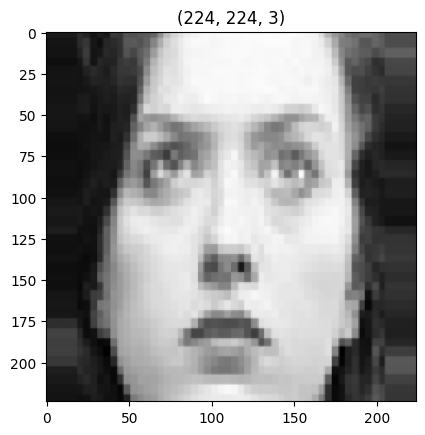

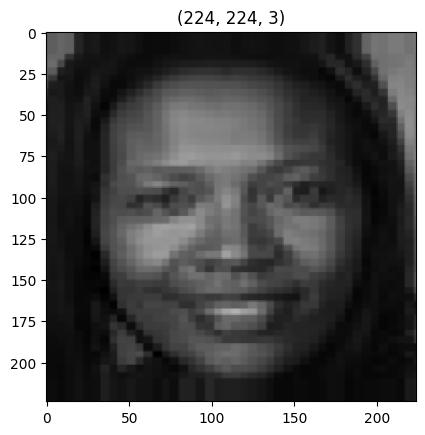

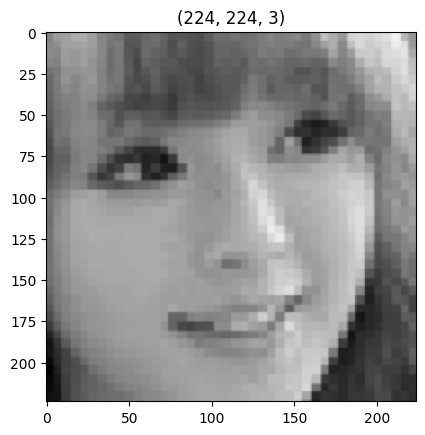

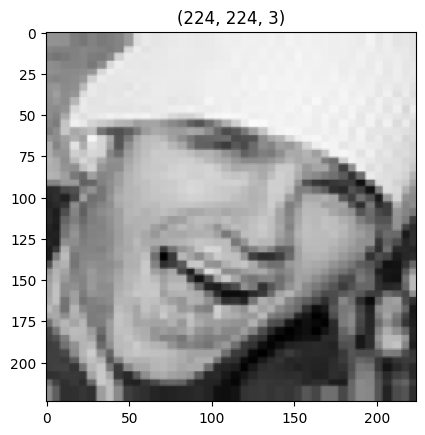

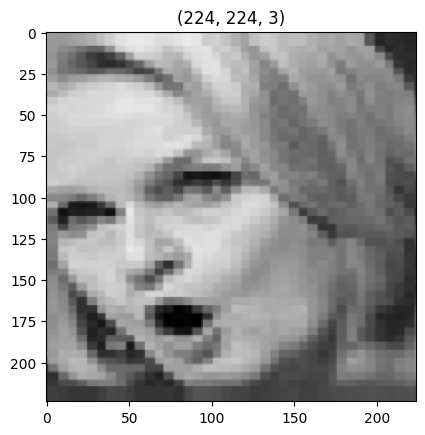

In [8]:
import matplotlib.pyplot as plt
t_img , label = train_data.next()
def plotImages(img_arr, label):
  count = 0
  for im,l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    count += 1
    if count == 5:
      break
plotImages(t_img,label)

In [9]:
input_shape = (224, 224, 3)  # Input shape matches individual image dimensions

model = Sequential()

# Add convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax', name='out_layer'))

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list
call_back = [es, mc]
"""
By using EarlyStopping, the training process will automatically stop
if the validation accuracy doesn't improve for a certain number of epochs,
helping you prevent overfitting and saving training time.
The ModelCheckpoint callback ensures that the best model
(based on validation accuracy) is saved during training.
"""
''

''

In [12]:
history = model.fit(train_data,
                    epochs=60,
                    batch_size=8,
                    validation_data=val_data,
                    callbacks=[es, mc],
                    use_multiprocessing=True)

Epoch 1/60
898/898 [==============================] - ETA: 0s - loss: 1.7213 - accuracy: 0.3126
Epoch 1: val_accuracy improved from -inf to 0.39774, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 995s 1s/step - loss: 1.7213 - accuracy: 0.3126 - val_loss: 1.5628 - val_accuracy: 0.3977
Epoch 2/60
898/898 [==============================] - ETA: 0s - loss: 1.4779 - accuracy: 0.4254
Epoch 2: val_accuracy improved from 0.39774 to 0.48217, saving model to best_model.h5
898/898 [==============================] - 958s 1s/step - loss: 1.4779 - accuracy: 0.4254 - val_loss: 1.3446 - val_accuracy: 0.4822
Epoch 3/60
898/898 [==============================] - ETA: 0s - loss: 1.3457 - accuracy: 0.4825
Epoch 3: val_accuracy improved from 0.48217 to 0.51435, saving model to best_model.h5
898/898 [==============================] - 914s 1s/step - loss: 1.3457 - accuracy: 0.4825 - val_loss: 1.2649 - val_accuracy: 0.5143
Epoch 4/60
898/898 [==============================] - ETA: 0s - loss: 1.2647 - accuracy: 0.5141
Epoch 4: val_accuracy improved from 0.51435 to 0.52313, saving model to best_model.h5
898/898 [==============================] - 903s 1s/step - 

In [13]:
# Loading the best fit model
from keras.models import load_model
model = load_model("/content/best_model.h5")

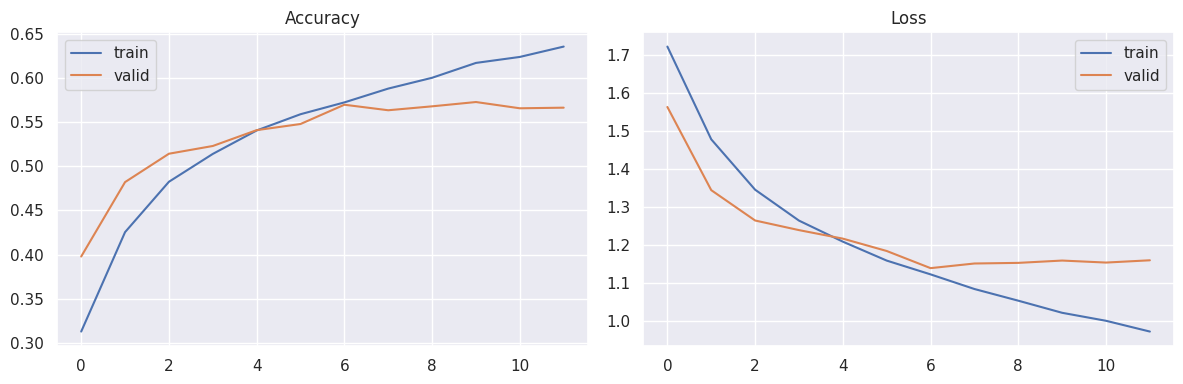

In [21]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch,y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch,y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

In [25]:
x_train, y_train = train_data.next()
x_test, y_test = val_data.next()

In [49]:
test_results = model.evaluate(x_test, y_test)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

1/1 [==============================] - 1s 606ms/step - loss: 1.3742 - accuracy: 0.5625
Test Loss: 1.374212622642517
Test Accuracy: 0.5625


In [50]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=1), y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes))

1/1 [==============================] - 0s 54ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.72        32
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.56        32
   macro avg       0.20      0.11      0.14        32
weighted avg       1.00      0.56      0.72        32

Confusion Matrix:
 [[18  2  2  4  6]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Enter the image path: /content/angry face.jpg
1/1 [==============================] - 0s 22ms/step


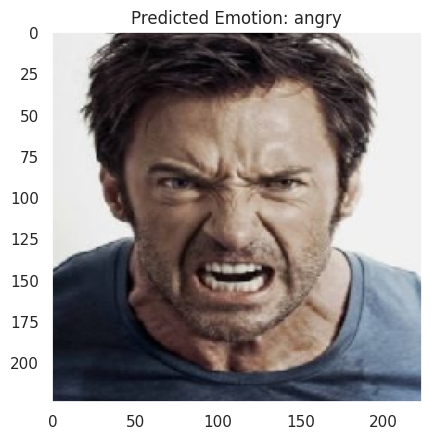

The predicted emotion is: angry


In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = input("Enter the image path: ")
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Normalize pixel values to [0, 1]

# Make predictions
predictions = model.predict(img)

# Get the class label with the highest probability
emotion_label = np.argmax(predictions)

emotions = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
predicted_emotion = emotions[emotion_label]

# Display the image
plt.imshow(image.array_to_img(img[0]))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.grid(False)
plt.show()

print(f"The predicted emotion is: {predicted_emotion}")